<a href="https://colab.research.google.com/github/Iftitahyr/Klasifikasi-Penyakit-Daun-Kopi-Menggunakan-Metode-Machine-Learning-Klasik-dan-CNN/blob/main/Klasifikasi_visualTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Penyakit Kopi menggunakan Visual Transformer (pre-trained)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

data_root = '/content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split'
splits = ['train', 'val', 'test']

print('\n'.join([f"{split}: {os.listdir(os.path.join(data_root,split))}" for split in splits]))
classes = sorted(os.listdir(os.path.join(data_root, 'train')))
print("Kelas:", classes)


train: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
val: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
test: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
Kelas: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']


TRAIN: {'Daun_Bercak': 1200, 'Daun_Karat': 1200, 'Daun_Sehat': 1200}
VAL: {'Daun_Bercak': 150, 'Daun_Karat': 150, 'Daun_Sehat': 150}
TEST: {'Daun_Bercak': 150, 'Daun_Karat': 150, 'Daun_Sehat': 150}


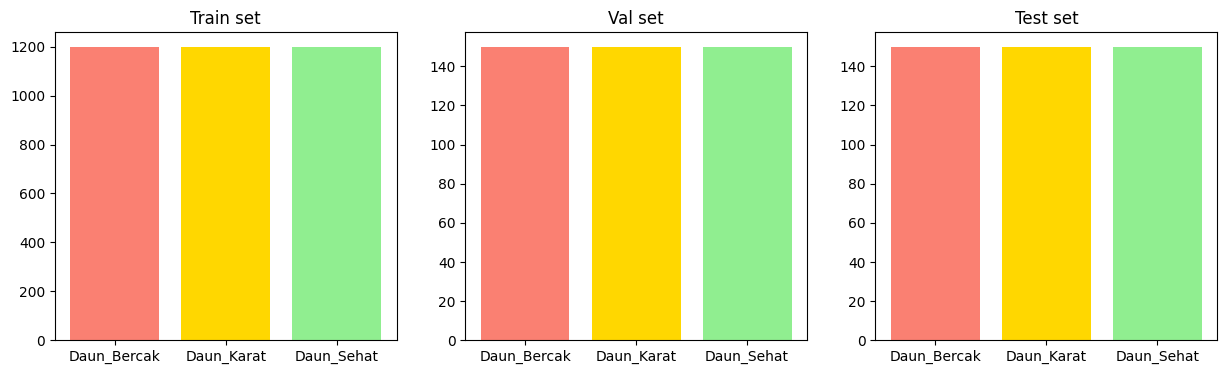

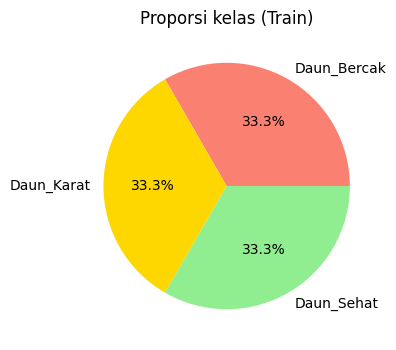

In [ ]:
import matplotlib.pyplot as plt

class_counts = {}
for split in splits:
    folder = os.path.join(data_root, split)
    class_counts[split] = {cls: len(os.listdir(os.path.join(folder, cls)))
                           for cls in classes if os.path.isdir(os.path.join(folder, cls))}
    print(f'{split.upper()}:', class_counts[split])

fig, axs = plt.subplots(1, 3, figsize=(15,4))
colors = ['salmon', 'gold', 'lightgreen'] if len(classes)==3 else None
for i, split in enumerate(splits):
    axs[i].bar(class_counts[split].keys(), class_counts[split].values(), color=colors)
    axs[i].set_title(f'{split.capitalize()} set')
plt.show()

plt.figure(figsize=(4,4))
plt.pie(list(class_counts['train'].values()), labels=class_counts['train'].keys(), autopct='%1.1f%%', colors=colors)
plt.title('Proporsi kelas (Train)')
plt.show()


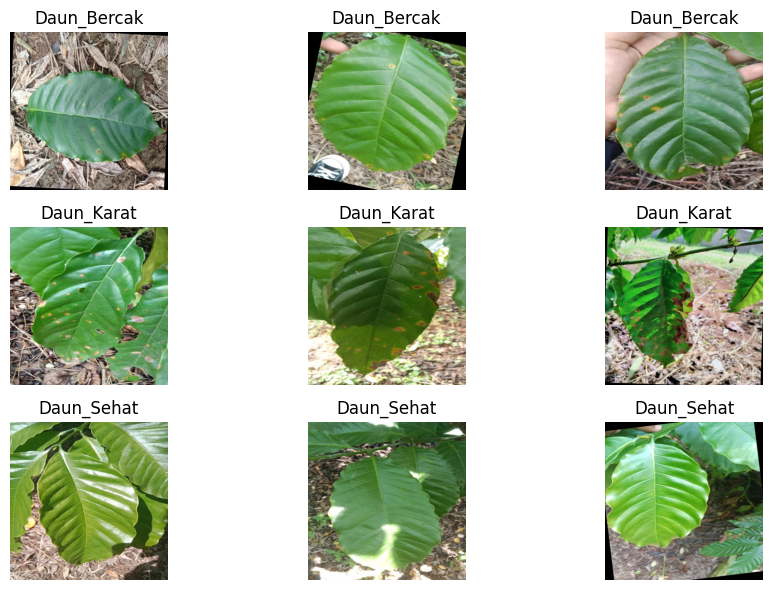

In [ ]:
import matplotlib.image as mpimg

num_samples = 3
plt.figure(figsize=(10, len(classes)*2))
for i, cls in enumerate(classes):
    folder = os.path.join(data_root, 'train', cls)
    imgs = os.listdir(folder)[:num_samples]
    for j, imgf in enumerate(imgs):
        ax = plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
        img = mpimg.imread(os.path.join(folder, imgf))
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import numpy as np

sizes, modes = [], []
sample_kelas = classes
for cls in sample_kelas:
    class_folder = os.path.join(data_root, 'train', cls)
    for f in os.listdir(class_folder)[:15]:
        img_path = os.path.join(class_folder, f)
        with Image.open(img_path) as img:
            sizes.append(img.size)
            modes.append(img.mode)
sizes = np.array(sizes)
print("Rata-rata ukuran (WxH):", np.mean(sizes, axis=0).astype(int))
print("Min:", np.min(sizes, axis=0), "Max:", np.max(sizes, axis=0))
print("Tipe gambar ditemukan:", set(modes))


Rata-rata ukuran (WxH): [640 640]
Min: [640 640] Max: [640 640]
Tipe gambar ditemukan: {'RGB'}


Histogram channel warna:


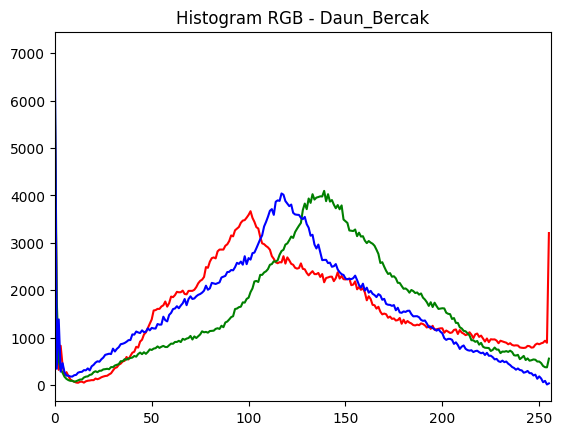

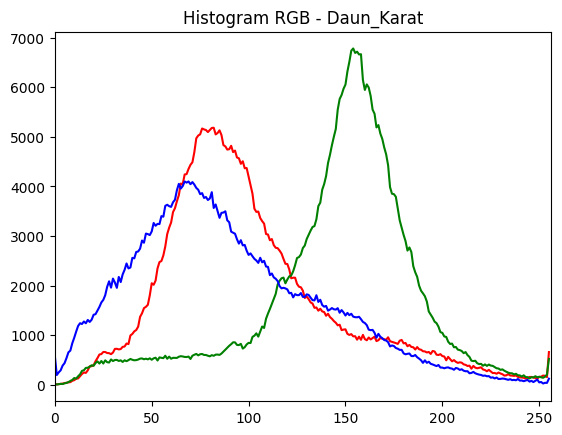

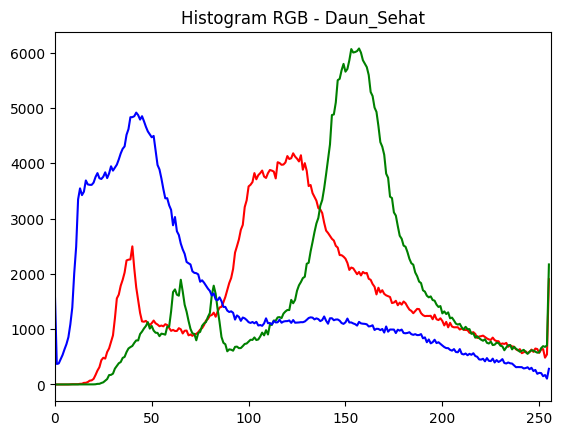

In [ ]:
import cv2

def plot_histogram_rgb(image_path, kelas):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = ('r','g','b')
    for i, col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.title(f"Histogram RGB - {kelas}")
    plt.xlim([0,256])
    plt.show()

print("Histogram channel warna:")
for cls in classes:
    f = os.listdir(os.path.join(data_root,'train',cls))[0]
    sample_img = os.path.join(data_root,'train',cls,f)
    plot_histogram_rgb(sample_img, cls)


In [ ]:
from PIL import ImageStat

def is_blurry(image_path, threshold=20):
    img = Image.open(image_path).convert('L')
    stat = ImageStat.Stat(img)
    return stat.stddev[0] < threshold

for cls in classes:
    class_folder = os.path.join(data_root,'train',cls)
    blurs = []
    for f in os.listdir(class_folder)[:20]:
        img_path = os.path.join(class_folder,f)
        if is_blurry(img_path):
            blurs.append(f)
    print(f'Kelas {cls}: {len(blurs)} gambar dideteksi buram (sample: {blurs[:2]})')


Kelas Daun_Bercak: 0 gambar dideteksi buram (sample: [])
Kelas Daun_Karat: 0 gambar dideteksi buram (sample: [])
Kelas Daun_Sehat: 0 gambar dideteksi buram (sample: [])


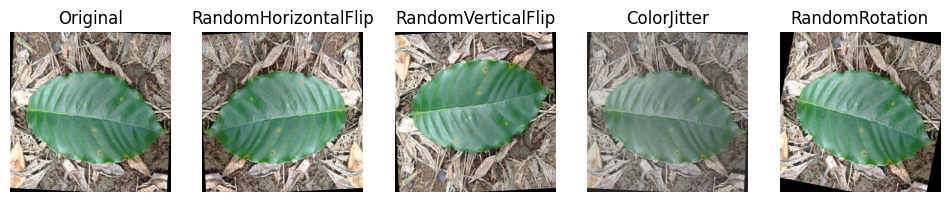

In [ ]:
import torchvision.transforms as T

sample_img_path = os.path.join(data_root,'train',classes[0],os.listdir(os.path.join(data_root,'train',classes[0]))[0])
image = Image.open(sample_img_path)
augments = [
    T.RandomHorizontalFlip(p=1),
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4),
    T.RandomRotation(30)
]

plt.figure(figsize=(12,3))
plt.subplot(1,5,1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')
for ix, tf in enumerate(augments):
    aug_img = tf(image)
    plt.subplot(1,5,ix+2)
    plt.imshow(aug_img)
    plt.title(tf.__class__.__name__)
    plt.axis('off')
plt.show()


In [ ]:
!pip install -q transformers datasets timm scikit-learn
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score


In [ ]:
data_files = {
    "train": os.path.join(data_root, "train", "**"),
    "validation": os.path.join(data_root, "val", "**"),
    "test": os.path.join(data_root, "test", "**")
}
dataset = load_dataset("imagefolder", data_files=data_files)
labels = dataset['train'].features['label'].names
print("Kelas label:", labels)


Resolving data files:   0%|          | 0/3600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Kelas label: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']


In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): lbl for i, lbl in enumerate(labels)},
    label2id={lbl: str(i) for i, lbl in enumerate(labels)}
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
# ==== AUGMENTASI KHUSUS TRAIN ====
import torchvision.transforms as T

train_augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4),
    T.RandomRotation(30),
])

# Transform untuk TRAIN (pakai augmentasi)
def transform_train(example):
    img = example["image"].convert("RGB")
    img = train_augment(img)  # augmentasi di sini
    inputs = image_processor(img, return_tensors="pt")
    result = {k: v.squeeze() for k, v in inputs.items()}
    result["label"] = example["label"]
    return result

# Transform untuk VAL & TEST (tanpa augmentasi)
def transform_eval(example):
    img = example["image"].convert("RGB")
    inputs = image_processor(img, return_tensors="pt")
    result = {k: v.squeeze() for k, v in inputs.items()}
    result["label"] = example["label"]
    return result

prepared_ds = {}
prepared_ds["train"] = dataset["train"].map(transform_train)
prepared_ds["validation"] = dataset["validation"].map(transform_eval)
prepared_ds["test"] = dataset["test"].map(transform_eval)

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-daunkopi-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    learning_rate=3e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()


/tmp/ipython-input-1416078788.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.200200,0.166323,0.948889
2,0.069900,0.117311,0.968889
3,0.075800,0.120803,0.966667
4,0.027700,0.101741,0.977778
5,0.014100,0.091664,0.977778


TrainOutput(global_step=1125, training_loss=0.10967675081888835, metrics={'train_runtime': 2851.3252, 'train_samples_per_second': 6.313, 'train_steps_per_second': 0.395, 'total_flos': 1.394868314714112e+18, 'train_loss': 0.10967675081888835, 'epoch': 5.0})

Sedang melakukan prediksi pada data test...



CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Daun_Bercak       0.99      0.90      0.94       150
  Daun_Karat       0.97      0.98      0.97       150
  Daun_Sehat       0.93      1.00      0.96       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



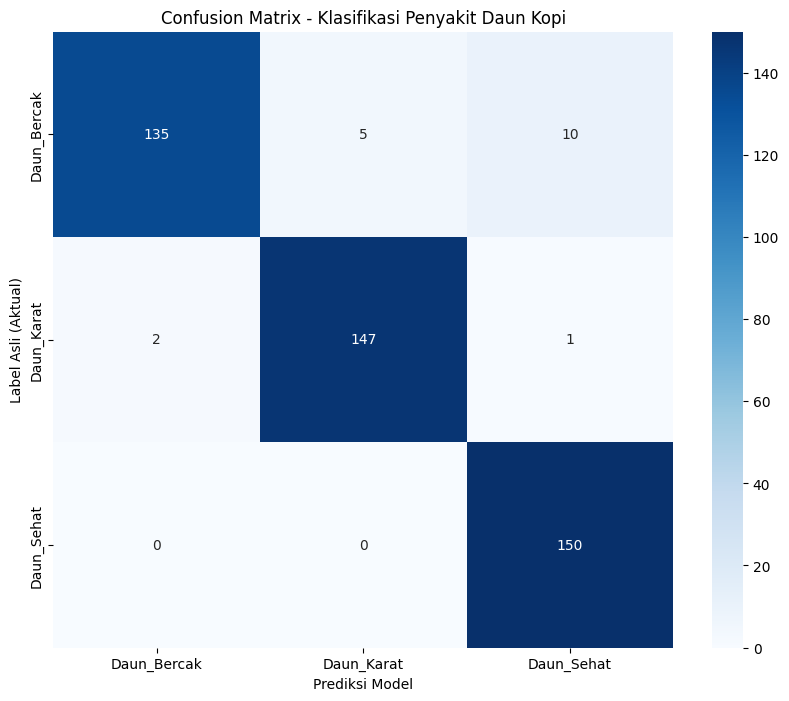

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Lakukan prediksi pada Test Set
print("Sedang melakukan prediksi pada data test...")
predictions = trainer.predict(prepared_ds["test"])

# 2. Ambil hasil prediksi (logits) dan label asli
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# 3. Tampilkan Classification Report (Precision, Recall, F1-Score)
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(true_labels, preds, target_names=labels))

# 4. Buat Confusion Matrix
cm = confusion_matrix(true_labels, preds)

# 5. Visualisasi Confusion Matrix dengan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title('Confusion Matrix - Klasifikasi Penyakit Daun Kopi')
plt.show()

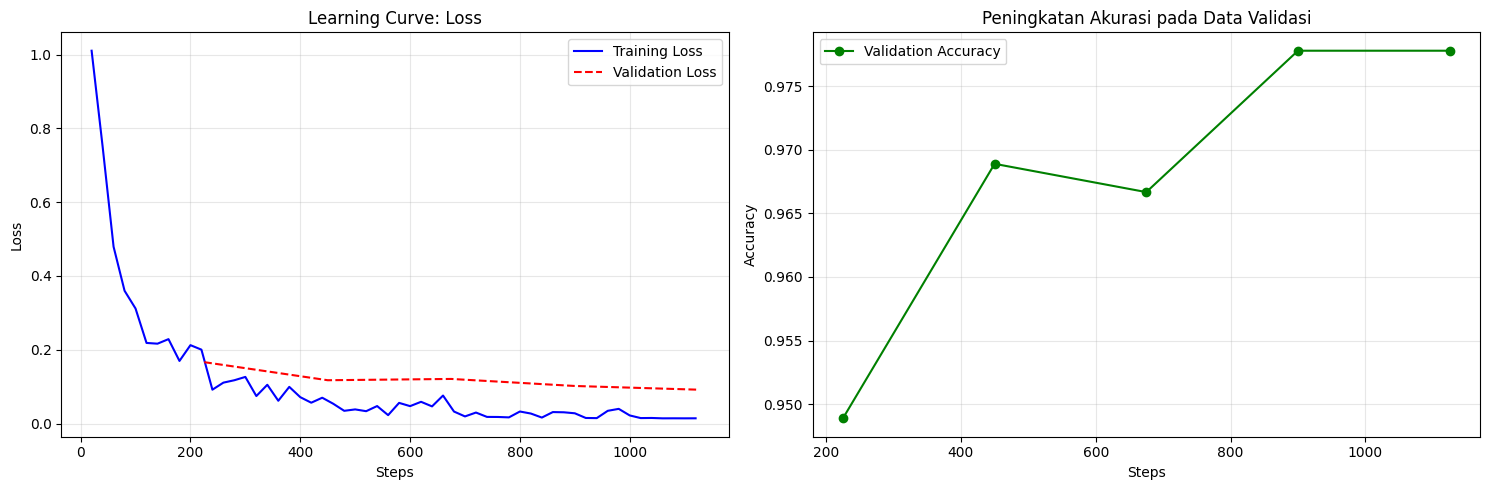

In [ ]:
# Mengambil data history dari trainer
history = trainer.state.log_history

# Mengekstrak data Training Loss
train_loss = []
train_steps = []
for x in history:
    if 'loss' in x:
        train_loss.append(x['loss'])
        train_steps.append(x['step'])

# Mengekstrak data Validation (Loss & Accuracy)
val_loss = []
val_acc = []
val_steps = []
for x in history:
    if 'eval_loss' in x:
        val_loss.append(x['eval_loss'])
        val_acc.append(x['eval_accuracy'])
        val_steps.append(x['step'])

# Plotting Grafik
plt.figure(figsize=(15, 5))

# Grafik 1: Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(val_steps, val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Grafik 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_steps, val_acc, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Peningkatan Akurasi pada Data Validasi')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
results = trainer.evaluate(prepared_ds["test"])
print("Test set accuracy:", results.get("eval_accuracy", None))


Test set accuracy: 0.96


In [ ]:
from PIL import Image

img_path = os.path.join(data_root, 'test', labels[0], os.listdir(os.path.join(data_root, 'test', labels[0]))[0])
image = Image.open(img_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt").to(model.device)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_class = logits.argmax(-1).item()
print("Prediksi kelas:", model.config.id2label[str(pred_class)])

Prediksi kelas: Daun_Bercak


#**Prediksi Gambar secara langsung**

Silakan upload gambar daun kopi (file .jpg atau .png)


Saving Daun_Bercak_0441.jpg to Daun_Bercak_0441.jpg


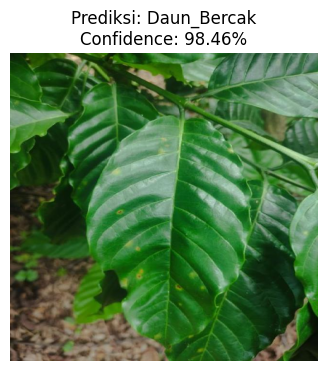

In [ ]:
from google.colab import files
from PIL import Image
import torch

# 1. Upload Gambar dari Komputer
print("Silakan upload gambar daun kopi (file .jpg atau .png)")
uploaded = files.upload()

# Ambil nama file yang baru diupload
filename = next(iter(uploaded))

# 2. Proses Gambar
image = Image.open(filename).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt").to(model.device)

# 3. Prediksi
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[str(predicted_class_idx)]
    confidence = torch.nn.functional.softmax(logits, dim=-1).max().item()

# 4. Tampilkan Hasil
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence:.2%}")
plt.show()